In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import datetime
from PIL import Image, ImageStat
import math
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Add
from tensorflow.keras.initializers import RandomNormal
# %load_ext tensorboard

In [2]:
# Enable GPU and check available devices
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [4]:
#seeding
seed = 2021
np.random.seed = seed
tf.seed = seed

In [5]:
train_rles=pd.read_csv('/kaggle/input/blood-vessel-segmentation/train_rles.csv')
sample=pd.read_csv('/kaggle/input/blood-vessel-segmentation/sample_submission.csv')

In [6]:
kidney1_images = glob('/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/*.tif')
kidney1_labels = glob('/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/labels/*.tif')
kidney2_images = glob('/kaggle/input/blood-vessel-segmentation/train/kidney_2/images/*.tif')
kidney2_labels = glob('/kaggle/input/blood-vessel-segmentation/train/kidney_2/labels/*.tif')
kidney3_images = glob('/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images/*.tif')
kidney3_labels = glob('/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/labels/*.tif')
kidney5_images = glob('/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/*.tif')
kidney6_images = glob('/kaggle/input/blood-vessel-segmentation/test/kidney_6/images/*.tif')

In [7]:
kidney1_df=pd.DataFrame([kidney1_images,kidney1_labels],index=['images','masks']).T
kidney2_df=pd.DataFrame([kidney2_images,kidney2_labels],index=['images','masks']).T
kidney3_df=pd.DataFrame([kidney3_images,kidney3_labels],index=['images','masks']).T

In [8]:
kidney1_df.head(3).values[0]

array(['/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/1259.tif',
       '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/labels/1259.tif'],
      dtype=object)

In [9]:
kidney2_df.head(3).values[0]

array(['/kaggle/input/blood-vessel-segmentation/train/kidney_2/images/1259.tif',
       '/kaggle/input/blood-vessel-segmentation/train/kidney_2/labels/1259.tif'],
      dtype=object)

In [10]:
kidney3_df.head(3).values[0]

array(['/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images/0301.tif',
       '/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/labels/0301.tif'],
      dtype=object)

In [11]:
train_rles.head()

,id,rle
0,kidney_1_dense_0000,1 0
1,kidney_1_dense_0001,1 0
2,kidney_1_dense_0002,1 0
3,kidney_1_dense_0003,1 0
4,kidney_1_dense_0004,1 0


In [12]:
sample

,id,rle
0,kidney_5_0000,1 1 100 10
1,kidney_5_0001,1 1 100 10
2,kidney_6_0000,1 0
3,kidney_6_0001,1 0


In [13]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [14]:
from tifffile import tifffile
from tensorflow.keras.utils import Sequence
import albumentations as A

In [15]:
# Hyperparameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1
CLASSES = 1
BATCH_SIZE = 4

In [16]:
# import cv2

In [50]:
class CustomDataGenerator(Sequence):
    def __init__(self, data_dict, batch_size=32, shuffle=True, augment=True,is_train=True):
        self.data_dict = data_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(data_dict['images']))
        self.is_train=is_train

        if shuffle:
            np.random.shuffle(self.indexes)

        # Albumentations augmentation pipeline
        self.train_transform = A.Compose([
            A.Rotate(limit=45, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
#             A.RandomScale(scale_limit=(0.8,1.25),interpolation=cv2.INTER_CUBIC,p=1),
            A.MotionBlur(p=0.5),
#             A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.4),
#             A.Resize(512,512)
#             A.CenterCrop(512,512),
#             A.GaussianBlur(p=1),#0.2
#             A.RandomGamma(gamma_limit=(100,110),p=1),
            A.RandomBrightness(limit=0.1,p=0.2),#0.2
#             A.CropNonEmptyMaskIfExists(512,512),
            A.RandomContrast(p=0.4),
#             A.ElasticTransform(p=0.5),
#             A.RandomScale(scale_limit=0.5,p=1),
            A.RandomCrop(512,512),
        ])
        
        self.val_transform = A.Compose([
            A.CenterCrop(512,512),
            # Add more augmentations as needed
        ])

    def __len__(self):
        return int(np.ceil(len(self.data_dict['images']) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        batch_indexes = self.indexes[start:end]

        batch_images = [self.load_tiff_image(self.data_dict['images'][i]) for i in batch_indexes]
        batch_masks = [self.load_tiff_mask(self.data_dict['masks'][i]) for i in batch_indexes]

        if self.augment:
            # Apply albumentations augmentation to the batch
            batch_images, batch_masks = self.augment_batch(batch_images, batch_masks)

        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_tiff_image(self, image_path):
        img = tifffile.imread(image_path)
        # Normalize pixel values to be between 0 and 1
        img = img / 2**16
        
        # Min-max normalization
        min_value = np.min(img)
        max_value = np.max(img)

        img = (img - min_value) / (max_value - min_value+1e-9)
        return img

    def load_tiff_mask(self, mask_path):
        mask = tifffile.imread(mask_path)
        # Convert to binary mask if needed
        mask = (mask > 0).astype(np.float32)
#         mask=mask.astype('float32')
        return mask

    def augment_batch(self, images, masks):
        augmented_images = []
        augmented_masks = []

        for i in range(len(images)):
            # Convert images and masks to uint8 for augmentation
            images_uint8 = (images[i] * 255).astype(np.uint8)
            masks_uint8 = (masks[i] * 255).astype(np.uint8)
#             images_uint8=images[i]
#             masks_uint8=masks[i]

            # Apply albumentations augmentation
            if self.is_train:
                augmented = self.train_transform(image=images_uint8, mask=masks_uint8)
                augmented_image = augmented['image']/255.   # Normalize back to [0, 1]
                augmented_mask = augmented['mask']/255.
            else:
                augmented = self.val_transform(image=images_uint8, mask=masks_uint8)
                augmented_image = augmented['image']/255.   # Normalize back to [0, 1]
                augmented_mask = augmented['mask']/255.

            augmented_images.append(augmented_image)
            augmented_masks.append(augmented_mask)

        return augmented_images, augmented_masks

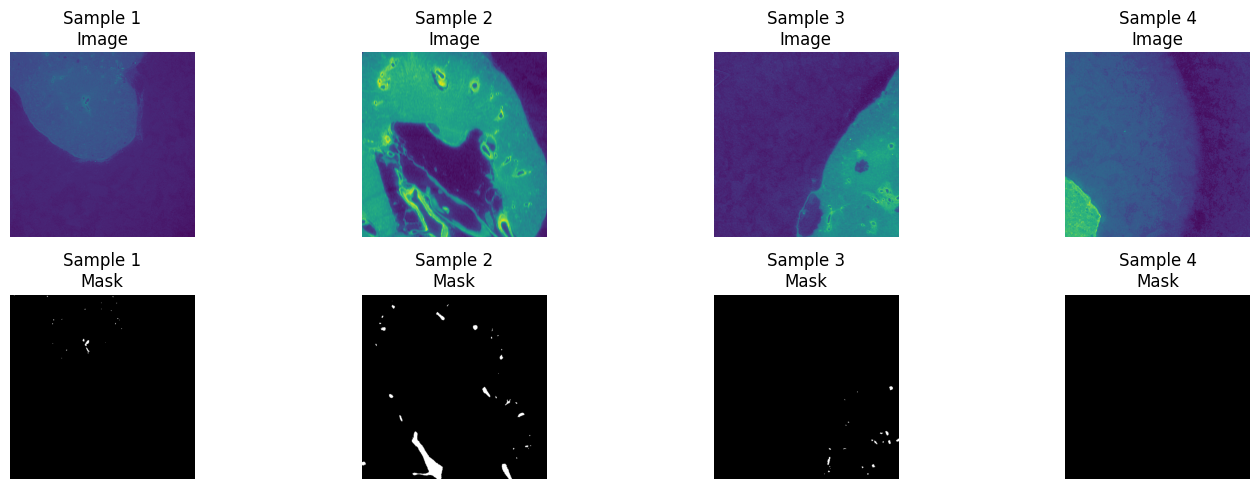

In [51]:
# import matplotlib.pyplot as plt


batch_size = 4

train_data_generator = CustomDataGenerator(kidney3_df, batch_size=batch_size)
val_data_generator = CustomDataGenerator(kidney1_df, batch_size=batch_size,shuffle=False,is_train=False)
# batch_size = 4

# train_data_generator = CustomDataGenerator(X_train, batch_size=batch_size)

# Get a batch from the data generator
sample_images, sample_masks = train_data_generator.__getitem__(0)

# Plot sample images and masks
def plot_samples(images, masks):
    num_samples = len(images)
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        axes[0, i].imshow(images[i])
        axes[0, i].set_title(f'Sample {i + 1}\nImage')
        axes[0, i].axis('off')

        axes[1, i].imshow(masks[i], cmap='gray')
        axes[1, i].set_title(f'Sample {i + 1}\nMask')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot sample images and masks
plot_samples(sample_images, sample_masks)

In [19]:
# Hyperparameters
BN_MOMENTUM = 0.1
BN_EPSILON = 1e-5
INITIALIZER = 'he_normal'

In [20]:
# Functions to build layers
def conv(x, outsize, kernel_size, strides_=1, padding_='same', activation=None):
    return Conv2D(outsize, kernel_size, strides=strides_, padding=padding_, 
                  kernel_initializer=INITIALIZER, use_bias=False, 
                  activation=activation)(x)

def BasicBlock(x, size, downsampe=False):
    residual = x

    out = conv(x, size, 3)
    out = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(out)
    out = Activation('relu')(out)

    out = conv(out, size, 3)
    out = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(out)

    if downsampe:
        residual = conv(x, size, 1, padding_='valid')
        residual = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(residual)

    out = Add()([out, residual])
    out = Activation('relu')(out)

    return out

def BottleNeckBlock(x, size, downsampe=False):
    residual = x

    out = conv(x, size, 1, padding_='valid')
    out = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(out)
    out = Activation('relu')(out)

    out = conv(out, size, 3)
    out = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(out)
    out = Activation('relu')(out)

    out = conv(out, size * 4, 1, padding_='valid')
    out = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(out)

    if downsampe:
        residual = conv(x, size * 4, 1, padding_='valid')
        residual = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(residual)

    out = Add()([out, residual])
    out = Activation('relu')(out)

    return out

def layer1(x):
    x = BottleNeckBlock(x, 64, downsampe=True)
    x = BottleNeckBlock(x, 64)
    x = BottleNeckBlock(x, 64)
    x = BottleNeckBlock(x, 64)

    return x

def transition_layer(x, in_channels, out_channels):
    num_in = len(in_channels)
    num_out = len(out_channels)
    out = []

    for i in range(num_out):
        if i < num_in:
            if in_channels[i] != out_channels[i]:
                residual = conv(x[i], out_channels[i], 3)
                residual = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(residual)
                residual = Activation('relu')(residual)
                out.append(residual)
            else:
                out.append(x[i])
        else:
            residual = conv(x[-1], out_channels[i], 3, strides_=2)
            residual = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(residual)
            residual = Activation('relu')(residual)
            out.append(residual)

    return out

def branches(x, block_num, channels):
    out = []
    for i in range(len(channels)):
        residual = x[i]
        for j in range(block_num):
            residual = BasicBlock(residual, channels[i])
        out.append(residual)
    return out

def fuse_layers(x, channels, multi_scale_output=True):
    out = []

    for i in range(len(channels) if multi_scale_output else 1):
        residual = x[i]
        for j in range(len(channels)):
            if j > i:
                y = conv(x[j], channels[i], 1, padding_='valid')
                y = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(y)
                y = UpSampling2D(size=2 ** (j - i))(y)
                residual = Add()([residual, y])
            elif j < i:
                y = x[j]
                for k in range(i - j):
                    if k == i - j - 1:
                        y = conv(y, channels[i], 3, strides_=2)
                        y = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(y)
                    else:
                        y = conv(y, channels[j], 3, strides_=2)
                        y = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(y)
                        y = Activation('relu')(y)
                residual = Add()([residual, y])

        residual = Activation('relu')(residual)
        out.append(residual)

    return out

In [21]:
# Functions to create model
def HighResolutionModule(x, channels, multi_scale_output=True):
    residual = branches(x, 4, channels)
    out = fuse_layers(residual, channels, multi_scale_output=multi_scale_output)
    return out


def stage(x, num_modules, channels, multi_scale_output=True):
    out = x
    for i in range(num_modules):
        if i == num_modules - 1 and multi_scale_output == False:
            out = HighResolutionModule(out, channels, multi_scale_output=False)
        else:
            out = HighResolutionModule(out, channels)

    return out


def hrnet_keras(input_size=(512,512, 1)):
    channels_2 = [32, 64]
    channels_3 = [32, 64, 128]
    channels_4 = [32, 64, 128, 256]
    num_modules_2 = 1
    num_modules_3 = 4
    num_modules_4 = 3

    inputs = Input(input_size)
    x = conv(inputs, 64, 3, strides_=2)
    x = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(x)
    x = conv(x, 64, 3, strides_=2)
    x = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(x)
    x = Activation('relu')(x)

    la1 = layer1(x)
    tr1 = transition_layer([la1], [256], channels_2)
    st2 = stage(tr1, num_modules_2, channels_2)
    tr2 = transition_layer(st2, channels_2, channels_3)
    st3 = stage(tr2, num_modules_3, channels_3)
    tr3 = transition_layer(st3, channels_3, channels_4)
    st4 = stage(tr3, num_modules_4, channels_4, multi_scale_output=False)
    up1 = UpSampling2D()(st4[0])
    up1 = conv(up1, 32, 3)
    up1 = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(up1)
    up1 = Activation('relu')(up1)
    up2 = UpSampling2D()(up1)
    up2 = conv(up2, 32, 3)
    up2 = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM)(up2)
    up2 = Activation('relu')(up2)
    final = conv(up2, 1, 1, padding_='valid', activation='sigmoid')

    model = Model(inputs=inputs, outputs=final)

    return model


In [22]:
def dice_loss(y_true, y_pred, smooth=0.0000001):
    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1)
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice
def dice_score(y_true, y_pred, smooth=0.0000001):
    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1)
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice

In [23]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [54]:
def step_decay(epoch):
    initial_lr = 0.0001
    drop = 0.1
    epochs_drop = 5
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr
# Use LearningRateScheduler callback during training
lr_scheduler = LearningRateScheduler(step_decay)

In [25]:
# def exp_decay(epoch):
#     initial_lr = 0.001
#     k = 0.1
#     lr = initial_lr * np.exp(-k * epoch)
#     return lr

# # Use LearningRateScheduler callback during training
# lr_scheduler = LearningRateScheduler(exp_decay)

In [26]:
def custom_loss(y_true, y_pred):
    threshold = 0.5
    y_pred_binary = tf.cast(tf.greater(y_pred, threshold), tf.float32)
    tp = tf.reduce_sum(y_true * y_pred_binary)
    fn = tf.reduce_sum(y_true * (1 - y_pred_binary))
    recall = (tp+1e-7) / (tp + fn + 1e-7)
    return 1-recall

In [27]:
with strategy.scope():
    model = hrnet_keras()
    model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_score,custom_loss])

In [28]:
dense=os.listdir('/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense/labels')

In [29]:
df=pd.DataFrame(dense,columns=['dense'])

In [30]:
df['images']=df.dense.apply(lambda x:f'/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images/{x}')
df['masks']=df.dense.apply(lambda x:f'/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense/labels/{x}')

# Now mix kindney1 and kidney3 for train and kidney3 sparse for validation

In [31]:
df_train=pd.concat([kidney1_df,df]).reset_index(drop=True)
# df_valid=pd.concat([kidney2_df,kidney3_df]).reset_index(drop=True) take much time

In [52]:
train_data_generator = CustomDataGenerator(df_train, batch_size=batch_size)
val_data_generator = CustomDataGenerator(kidney3_df, batch_size=batch_size*2,shuffle=False,is_train=False)

In [33]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

class CustomModelCheckpoint(Callback):
    def __init__(self, monitor_metrics, save_weights_only=True):
        super(CustomModelCheckpoint, self).__init__()
        self.monitor_metrics = monitor_metrics
        self.save_weights_only = save_weights_only

    def on_epoch_end(self, epoch, logs=None):
        current_values = {metric: logs.get(metric) for metric in self.monitor_metrics}
        if current_values["val_dice_score"]>0.85 and current_values["val_custom_loss"]<0.10:
            self.model.save_weights(f'./model_weights_{current_values["val_dice_score"]}_{current_values["val_custom_loss"]}.h5')
            self.model.stop_training = True
        elif current_values["val_dice_score"]>0.85 and current_values["val_custom_loss"]<0.20:
            self.model.save_weights(f'./model_weights_{current_values["val_dice_score"]}_{current_values["val_custom_loss"]}.h5')
        else:
            pass
        
        
model_checkpoint = CustomModelCheckpoint(
    monitor_metrics=['val_dice_score', 'val_custom_loss'],
    save_weights_only=True
)

In [56]:
history = model.fit(train_data_generator,
                    initial_epoch=20,
                    epochs=50, 
                    callbacks=[lr_scheduler,model_checkpoint],
                    validation_data=val_data_generator)

Epoch 21/50
695/695 [==============================] - 311s 447ms/step - loss: 0.1293 - dice_score: 0.8707 - custom_loss: 0.1633 - val_loss: 0.1191 - val_dice_score: 0.8809 - val_custom_loss: 0.3225 - lr: 1.0000e-08
Epoch 22/50
695/695 [==============================] - 309s 445ms/step - loss: 0.1300 - dice_score: 0.8700 - custom_loss: 0.1689 - val_loss: 0.0981 - val_dice_score: 0.9019 - val_custom_loss: 0.2231 - lr: 1.0000e-08
Epoch 23/50
695/695 [==============================] - 312s 448ms/step - loss: 0.1286 - dice_score: 0.8714 - custom_loss: 0.1674 - val_loss: 0.0905 - val_dice_score: 0.9095 - val_custom_loss: 0.1990 - lr: 1.0000e-08
Epoch 24/50
695/695 [==============================] - 308s 443ms/step - loss: 0.1307 - dice_score: 0.8693 - custom_loss: 0.1619 - val_loss: 0.1045 - val_dice_score: 0.8955 - val_custom_loss: 0.2654 - lr: 1.0000e-08
Epoch 25/50
695/695 [==============================] - 311s 447ms/step - loss: 0.1293 - dice_score: 0.8707 - custom_loss: 0.1662 - val_l

KeyboardInterrupt: 

In [64]:
model.load_weights('/kaggle/working/model_weights_0.9115426540374756_0.14422346651554108.h5')

In [65]:
val_data_generator = CustomDataGenerator(kidney1_df, batch_size=batch_size,shuffle=True,is_train=False)
model.evaluate(val_data_generator)

570/570 [==============================] - 73s 128ms/step - loss: 0.1399 - dice_score: 0.8601 - custom_loss: 0.1183


[0.1399296075105667, 0.8600703477859497, 0.11827880144119263]

In [66]:
val_data_generator = CustomDataGenerator(kidney2_df, batch_size=batch_size,shuffle=True,is_train=False)
model.evaluate(val_data_generator)

555/555 [==============================] - 150s 270ms/step - loss: 0.0767 - dice_score: 0.9233 - custom_loss: 0.0879


[0.07669821381568909, 0.9233019351959229, 0.08789610862731934]

In [67]:
val_data_generator = CustomDataGenerator(kidney3_df, batch_size=batch_size,shuffle=True,is_train=False)
model.evaluate(val_data_generator)

259/259 [==============================] - 105s 405ms/step - loss: 0.0835 - dice_score: 0.9165 - custom_loss: 0.1295


[0.08345340192317963, 0.9165462851524353, 0.12953801453113556]

In [68]:
val_data_generator = CustomDataGenerator(df, batch_size=batch_size,shuffle=True,is_train=False)
model.evaluate(val_data_generator)

126/126 [==============================] - 49s 386ms/step - loss: 0.0870 - dice_score: 0.9130 - custom_loss: 0.1238


[0.08700433373451233, 0.9129956364631653, 0.12381332367658615]

In [60]:
val_data_generator = CustomDataGenerator(kidney1_df, batch_size=batch_size,shuffle=True,is_train=False)
model.evaluate(val_data_generator)

570/570 [==============================] - 51s 89ms/step - loss: 0.1283 - dice_score: 0.8717 - custom_loss: 0.1059


[0.12834268808364868, 0.8716572523117065, 0.10593564808368683]

In [61]:
val_data_generator = CustomDataGenerator(kidney2_df, batch_size=batch_size,shuffle=True,is_train=False)
model.evaluate(val_data_generator)

555/555 [==============================] - 156s 280ms/step - loss: 0.0781 - dice_score: 0.9219 - custom_loss: 0.0916


[0.07814245671033859, 0.9218574166297913, 0.09156348556280136]

In [62]:
val_data_generator = CustomDataGenerator(kidney3_df, batch_size=batch_size,shuffle=True,is_train=False)
model.evaluate(val_data_generator)

259/259 [==============================] - 43s 164ms/step - loss: 0.0867 - dice_score: 0.9133 - custom_loss: 0.1571


[0.08673039078712463, 0.9132697582244873, 0.15708377957344055]

In [63]:
val_data_generator = CustomDataGenerator(df, batch_size=batch_size,shuffle=True,is_train=False)
model.evaluate(val_data_generator)

126/126 [==============================] - 21s 168ms/step - loss: 0.0912 - dice_score: 0.9088 - custom_loss: 0.1535


[0.09117241948843002, 0.9088273644447327, 0.15346366167068481]

1/1 [==============================] - 12s 12s/step


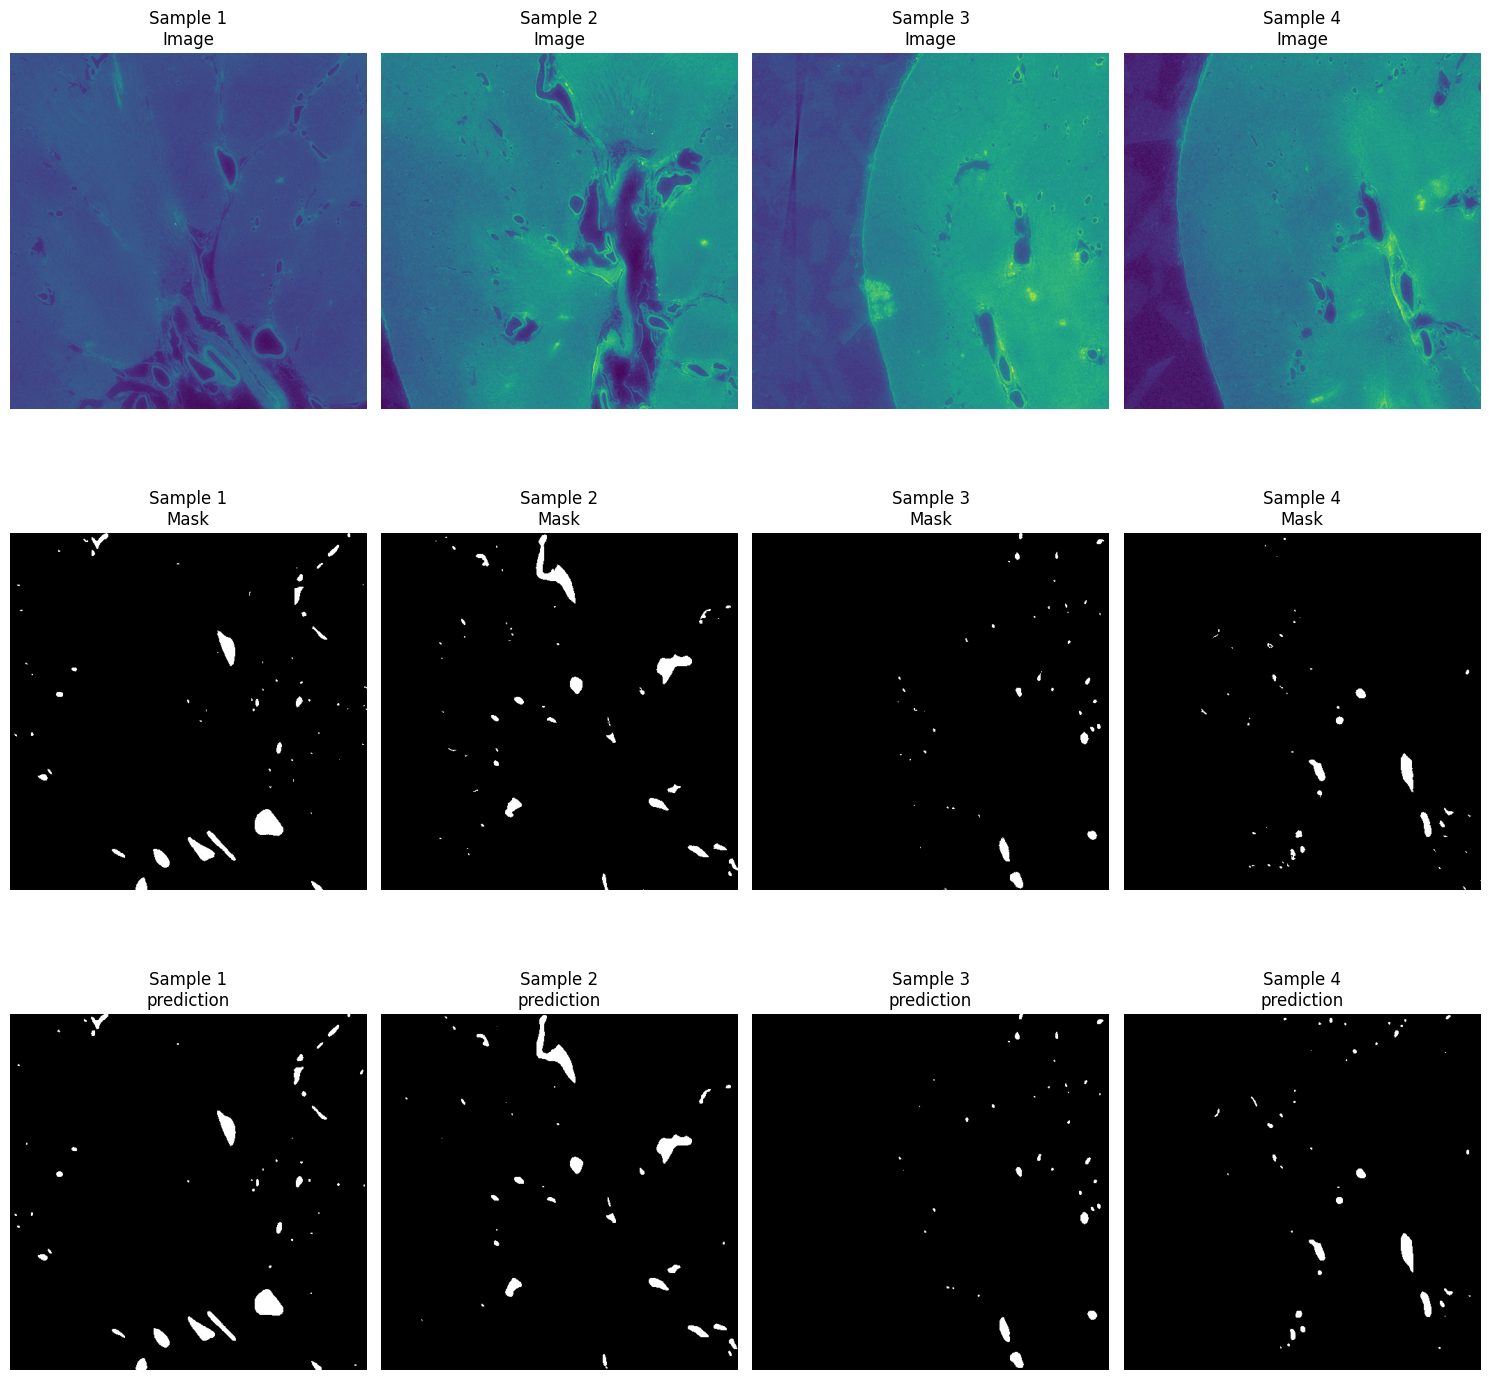

In [59]:
val_data_generator = CustomDataGenerator(kidney1_df, batch_size=batch_size,shuffle=True,is_train=False)
# Get a batch from the data generator
sample_images, sample_masks = val_data_generator.__getitem__(0)

# Plot sample images and masks
def plot_samples(images, masks):
    num_samples = len(images)
    
    pred=model.predict(images)
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 15))
    
    for i in range(num_samples):
        axes[0, i].imshow(images[i])
        axes[0, i].set_title(f'Sample {i + 1}\nImage')
        axes[0, i].axis('off')

        axes[1, i].imshow(masks[i], cmap='gray')
        axes[1, i].set_title(f'Sample {i + 1}\nMask')
        axes[1, i].axis('off')
        
        axes[2,i].imshow(pred[i].squeeze(),cmap='gray')
        axes[2, i].set_title(f'Sample {i + 1}\nprediction')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot sample images and masks
plot_samples(sample_images, sample_masks)

In [41]:
def encode_image_to_tiles(image, tile_size):

    # Calculate the number of tiles along rows and columns
    rows, cols = image.shape
    m, n = tile_size
    num_rows = rows // m
    num_cols = cols // n

    # Create a list to store tiles
    tiles = []

    # Iterate over the image and extract tiles
    for i in range(num_rows):
        for j in range(num_cols):
            tile = image[i * m: (i + 1) * m, j * n: (j + 1) * n]
            tiles.append(tile)

    return tiles

def decode_tiles_to_image(tiles, original_shape):
    # Calculate the number of tiles along rows and columns
    num_rows, num_cols = original_shape
    m, n = tiles[0].shape

    # Create an empty image to reconstruct
    reconstructed_image = np.zeros(original_shape, dtype=np.float16)

    # Iterate over the tiles and place them in the reconstructed image
    idx = 0
    for i in range(num_rows//m):
        for j in range(num_cols//n):
            tile = tiles[idx]
            reconstructed_image[i * m: (i + 1) * m, j * n: (j + 1) * n] = tile
            idx += 1

    return reconstructed_image

In [42]:
def rle_encode(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 0'
    return rle

In [43]:
kidney5_df=pd.DataFrame([kidney5_images],index=['images']).T
kidney6_df=pd.DataFrame([kidney6_images],index=['images']).T

In [44]:
test=pd.concat([kidney5_df,kidney6_df],axis=0)

In [45]:
test=test.sort_values('images').reset_index(drop=True)

In [46]:
from tqdm.notebook import tqdm

In [47]:
result=[]
for img_path in tqdm(test.images):
    img=tifffile.imread(img_path)
    img=img/2**16
#     print(img.min(),img.max())
    height,width=img.shape
    if height/512==height//512:
        rows=height/512
    else:
        rows=height//512+1
    if width/512==width//512:
        columns=width/512
    else:
        columns=width//512+1
    img=np.pad(img,((0,rows*512-height),(0,columns*512-width)),mode='constant',constant_values=0.2)
    img_list=encode_image_to_tiles(img,(512,512))
    tf_img=tf.convert_to_tensor(img_list)
    pred=model.predict(tf_img)
    pred=np.squeeze(pred)
    pred=np.where(pred>0.4,1,0)
    pred=decode_tiles_to_image(pred,(rows*512,columns*512))
    pred=pred[:height,:width]
    encode=rle_encode(pred)
    result.append(encode)

  0%|          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 0s 240ms/step


In [48]:
sample

,id,rle
0,kidney_5_0000,1 1 100 10
1,kidney_5_0001,1 1 100 10
2,kidney_6_0000,1 0
3,kidney_6_0001,1 0


In [49]:
test['id']=test.images.apply(lambda x:x.split('/')[5]+'_'+x.split('/')[7][:-4])

In [50]:
test['rle']=result

In [51]:
test

,images,id,rle
0,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_5_0000,29938 1 30849 3 31761 3 32674 2 33586 2 785089...
1,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_5_0001,29937 1 30848 2 31760 2 32672 2
2,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_5_0002,30847 3 31760 2 32672 2
3,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_6_0000,29938 1 30849 3 31761 3 32674 2 33586 2 785089...
4,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_6_0001,29937 1 30848 2 31760 2 32672 2
5,/kaggle/input/blood-vessel-segmentation/test/k...,kidney_6_0002,30847 3 31760 2 32672 2


In [52]:
test=test[['id','rle']]

In [ ]:
test.to_csv('submission.csv',index=False)